In [10]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [242]:
def calculateEpsilons(eigenVals, eigenVects, M): # only works for 2 agents
    eps_n = np.sqrt(M) * np.sum((np.abs(eigenVals[1:]) / (1 - np.abs(eigenVals[1:]))))
    eps_c = []
    for i in range(M):
        eps = 0
        vpos = 0
        vneg = 0
        b = 0
        if((eigenVects * np.transpose(eigenVects))[i,i] >= 0):
            for j in range(len(eigenVects) - 1):
                vpos += (eigenVects[i,j] * eigenVects[i,j+1])
        if((eigenVects * np.transpose(eigenVects))[i,i] <= 0):
            for j in range(len(eigenVects) - 1):
                vneg += (eigenVects[i,j] * eigenVects[i,j+1])
    
        if(eigenVals[0] * eigenVals[1] >= 0 and (eigenVects * np.transpose(eigenVects))[i,i] >= 0):
            b = vpos * (eigenVects * (np.transpose(eigenVects)))[i,i]
        elif(eigenVals[0] * eigenVals[1] >= 0 and (eigenVects * np.transpose(eigenVects))[i,i] <= 0):
            b = vneg * (eigenVects * (np.transpose(eigenVects)))[i,i]
        else:
            b = max(np.abs(vneg), vpos) * np.abs((eigenVects * np.transpose(eigenVects))[i,i])
    
        for p in range(M - 1):
            lambdas = np.abs(eigenVals[p] * eigenVals[p+1])
            eps += (lambdas / (1 - lambdas)) * b
        eps *= M
        eps_c.append(eps)
    return eps_n, eps_c

In [243]:
class Agent:
    def __init__(self, num_arms):
        # Number of total steps
        self.total_arm_selections = np.ones(num_arms)
        # Total reward for each arm
        self.arm_rewards = np.zeros(num_arms)
        # Total mean reward from all arms
        self.mean_rewards = self.arm_rewards / self.total_arm_selections
    
    def updateSelections(self, index):
        self.total_arm_selections[index] += 1
    
    def updateRewards(self, index, reward):
        self.arm_rewards[index] = reward
    
    def updateMeans(self):
        self.mean_rewards = self.arm_rewards / self.total_arm_selections

In [272]:
class Arm:
    def __init__(self):
        self.reward_distrib = np.abs(np.random.normal(0, 1))
    
    def getReward(self):
        return np.abs(np.random.normal(self.reward_distrib, 1))

In [367]:
N = 5 # number of arms
M = 4 # number of agents
arms = []
agents = []
arm_selections = []
arm_rewards = []
mean_rewards = []

indicators = np.zeros([M,N])
rewards = np.zeros([M,N])

T = 250 # time to run for
gamma = 1.5 # must be greater than 1 according to paper

for i in range(N): # initialize arms
    arms.append(Arm())

for i in range(M): # initialize agents
    agents.append(Agent(N))

for i in range(len(agents)): # get arrays of selections and rewards
    arm_selections.append(agents[i].total_arm_selections)
    arm_rewards.append(agents[i].arm_rewards)
arm_selections = np.array(arm_selections)
arm_rewards = np.array(arm_rewards)

for i in range(len(arms)): # initialize with 1 round of rewards
    for j in range(len(agents)):
        reward = arms[i].getReward()
        arm_rewards[j][i] = reward
mean_rewards = arm_rewards/arm_selections

In [368]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (0, 2), (1, 2), (0, 3)])
A = nx.adjacency_matrix(G)
L = nx.laplacian_matrix(G)

M = len(G)

maxDeg = 0
for i in range(len(G)): # find max degree in graph
    if G.degree[i] > maxDeg:
        maxDeg = G.degree[i]

kappa = .5
P = np.eye(len(G)) - (kappa*L / maxDeg) # calculate P matrix from paper
eigenVals, eigenVects = np.linalg.eig(P) # calculate P's eigenvectors and eigenvalues

_, eps_c = calculateEpsilons(eigenVals, eigenVects, M) # calculate epsilons eps_n and eps_c from paper

C:\Users\ethan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [378]:
eps_c

[-10.763458589892302,
 15.837401628514623,
 1.4861235086581912,
 -6.560066547280481]

In [370]:
reward = 0
sampledIndex = 0
maxRwd = 0
maxIndex = 0
sampledIndices = []
iter_rewards = np.zeros(T+1)
meanRwd = 0

for t in range(1,T+1):
    mean_rewards = arm_rewards/arm_selections # update u_i(t)
    arm_selections = P*arm_selections + P*indicators # update s_i(t)
    arm_rewards = P*arm_rewards + P*rewards # update n_i(t)
    indicators = np.zeros([M,N])
    rewards = np.zeros([M,N])
    for k in range(len(agents)):
        maxRwd = 0
        vals = []
        for i in range(len(arms)): # loop through arms to find max reward to decide which arm to choose
            val = mean_rewards[k,i] + np.sqrt((2*gamma) * ((arm_selections[k,i] + eps_c[k]) / (M*arm_selections[k,i])) * (np.log(t)/arm_selections[k,i]))
            vals.append(val)
            if val > maxRwd:
                maxRwd = val
                maxIndex = i
        sampledIndex = maxIndex # set index of chosen arm
        sampledIndices.append(sampledIndex)
        reward = arms[sampledIndex].getReward() # get reward from chosen arm
        meanRwd = meanRwd + (reward-meanRwd) / t
        indicators[k,sampledIndex] = 1 # set indicator to 1 for chosen arm
        rewards[k,sampledIndex] = reward # set r_i(t)
        iter_rewards[t] = meanRwd

C:\Users\ethan\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


In [371]:
mean_rewards

matrix([[1.15151674, 1.98797122, 0.79700072, 1.05090424, 1.15815479],
        [1.15164561, 1.98851386, 0.79699695, 1.05089987, 1.15812139],
        [1.15164558, 1.98681985, 0.79699695, 1.05089987, 1.15812139],
        [1.15125873, 1.98526986, 0.79700829, 1.05091297, 1.15822159]])

In [372]:
arm_selections

matrix([[ 10.75      , 215.        ,   7.5       ,   9.75      ,
          11.        ],
        [ 10.7536231 , 214.99335063,   7.50110556,   9.75142804,
          11.00049267],
        [ 10.75362262, 214.99335111,   7.50110555,   9.75142804,
          11.00049267],
        [ 10.74275428, 215.01329826,   7.49778889,   9.74714391,
          10.99901465]])

In [373]:
arm_rewards

matrix([[ 12.37880501, 426.49236449,   5.97750544,  10.2463163 ,
          12.73970265],
        [ 12.38413189, 426.0429947 ,   5.97836294,  10.24778158,
          12.7399671 ],
        [ 12.38413119, 426.03860237,   5.97836294,  10.24778157,
          12.7399671 ],
        [ 12.36815195, 426.83117566,   5.97579043,  10.24338574,
          12.73917375]])

In [374]:
for arm in arms:
    print(arm.reward_distrib)

0.9788624928890389
1.9337232821455075
0.35186267983584874
0.5949370547857896
0.7272301113175506


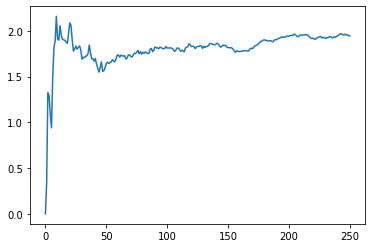

In [375]:
plt.plot(range(T+1), iter_rewards)